In [41]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt

In [42]:
#reading the data
df = pd.read_csv('escorts.txt', delim_whitespace=True, index_col=False)

df_copy = df.copy()
#creating new columns in df that adds: year, month and day
df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'], unit='s')

df_copy['year'] = df_copy['datetime'].dt.year
df_copy['month'] = df_copy['datetime'].dt.month
df_copy['day'] = df_copy['datetime'].dt.day

#dropping column datetime
df_copy = df_copy.drop(columns=['datetime'])



In [43]:
#getting rid of the timestamp
df_no_time = df.drop('timestamp', axis=1)
df_no_time.to_csv('escorts.csv', index =False, header=False)

df_no_time.head(10)

,n1,n2,e
0,1,1,0
1,1,2,1
2,1,3,0
3,2,1,0
4,3,4,0
5,3,4,0
6,4,5,0
7,5,6,0
8,6,7,1
9,6,8,1


In [44]:
#finding unique number of buyers and escorts
buyers = df.n1.unique().tolist()
escorts = df.n2.unique().tolist()

print(f'numbers of buyers: {len(buyers)}')
print(f'numbers of escorts: {len(escorts)}')


numbers of buyers: 10106
numbers of escorts: 6624


In [45]:
pop_buyers = df_no_time['n1'].value_counts().reset_index()
# pop_escorts = df_no_time['n2'].value_counts().to_frame()

pop_buyers.iloc[:10, 0:1]

,index
0,2283
1,244
2,4205
3,617
4,1443
5,2873
6,1223
7,8047
8,3348
9,1084


In [46]:
#finding most popular buyers(biggest amount of payments) and escorts(how many times visited)
#we need to observe that the escorts that had less buyers and had rating of 1, will have better scores than the most visited ones
#so we need to normalize it

#Making dataframe of popular buyers and popular escorts
pop_buyers = df_no_time['n1'].value_counts().reset_index()
pop_escorts = df_no_time['n2'].value_counts().reset_index()

#Making list of the 10 most popular buyers
b_top10 = pop_buyers['index'].head(10).tolist()
 
#Making list of the 10 most popular escorts
e_top10 = pop_escorts['index'].head(10).tolist()

In [47]:

#Dictionary of average rating of most vistied escorts (top 10 degrees)
#Key: ID of escort
#Value: Average rating
avg = {}
for escort in e_top10:
    most_pop_esc = df_no_time[df_no_time['n2'] == escort]
    ratings = most_pop_esc['e'].tolist()
    avg[escort] = round(sum(ratings)/len(ratings), 3)

print(avg)

{11: 0.98, 1565: 0.992, 1443: 0.96, 41: 0.942, 1345: 0.968, 2845: 0.977, 2470: 0.98, 1569: 0.953, 2799: 0.983, 503: 0.955}


In [48]:
#Creating network object of the network

G = nx.from_pandas_edgelist(df_no_time, 'n1', 'n2', 'e')

In [49]:
print(G.size()) #unique edge count
print(G.number_of_nodes())
print(df_no_time.shape[0]) #total number of rows (numebr of encounters)
print(pop_buyers['n1'].mean()) #average degree of buyers (how many escorts they rated)
print(pop_escorts['n2'].mean()) #average degreee of escorts (how many times they've been rated)
print(df_no_time['e'].mean()) #average rating (most of them satisfied ;))
print(nx.is_connected(G)) 

39024
10106
50632
5.0100930140510584
7.643719806763285
0.7426923684626323
True


In [50]:
#Largest Connected Component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
LCC = G.subgraph(Gcc[0])
print(LCC.size())
print(G.size() - LCC.size()) #how many unique edges are out of the LCC

39024
0


In [51]:
#creating different IDs for buyers(a) and escorts(b), so the nx function could read it
# df_no_time['n1'] = df_no_time['n1'].apply(lambda x: 'a' + x)
df_no_time['n1'] = 'a' + df_no_time['n1'].astype(str)

df_no_time['n2'] = 'b' + df_no_time['n2'].astype(str)
df_no_time.head()

#collapsing the edges where one buyer rated the same girl more than 1 time
main_df = df_no_time.groupby(['n1', 'n2'], as_index=False).mean()

print(len(main_df)-len(df_no_time))
print(len(df_no_time))

# main_df[(main_df['n1'] == "a2283")] #yes, it creates the means if they went to more than one escort

-11588
50632


In [52]:
#projecting the bipartite graph using vectorized projection
G = nx.from_pandas_edgelist(main_df, 'n1', 'n2', 'e')
nx.is_bipartite(G)
proj_G = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n2.unique(), ratio=True) #ratio is number of common neighbors devided by number of buyers

In [53]:
#basic network analysis on projected network
# proj_G.size() #num of edges
print(proj_G.number_of_edges())
print(proj_G.number_of_nodes())

print(proj_G.edges['b1','b2']) 

183465
6624
{'weight': 0.0006926578270334455}


In [54]:
# idea: in order to create more fair rating of escorts (normalize the retings) average the weights of edges of a specific node and
# use it as a weights to use on averaged rating on the node.
# this doesn't work, because it'd favor the most visited nodes

x = (len(G) - len(main_df.n2.unique())) #ratio=True when we project th network
rat1 = 1/x
rat600 = 615/x

#example scores
print(1*rat1)
print(0.98*rat600)

9.895111814763506e-05
0.059637838907579656


In [55]:
rat1 = 2/3
rat600 = 616/617
rat = 101/102

print(1*rat1)
print(0.98*rat600)
print(0.4*rat)

0.6666666666666666
0.9784116693679092
0.39607843137254906


### Laplace's Rule of Succesion 

In [56]:
# Define Laplace's Rule of Succession function with weighted ratings
def laplace_rule_of_succession(df, rating_weights={'positive': 1, 'neutral': 0.5, 'negative': -1}):
    # Calculate the total number of reviews for each escort
    reviews_count = df.groupby('n2')['e'].count().reset_index()
    reviews_count.rename(columns={'e': 'TotalReviews'}, inplace=True)

    # Calculate the total weight for each escort
    weighted_reviews = df.groupby(['n2'])['e'].sum().reset_index()
    weighted_reviews.rename(columns={'e': 'TotalWeight'}, inplace=True)

    # Merge the weight information back into the main dataframe
    df = pd.merge(df, reviews_count, on='n2', how='left')
    df = pd.merge(df, weighted_reviews, on='n2', how='left')

    # Calculate Laplace-adjusted ratings with weighted ratings
    df['LaplaceAdjustedRating'] = (df['TotalWeight'] + rating_weights['positive']) / (df['TotalReviews'] + sum(rating_weights.values()))

    return df



In [57]:
df_test = laplace_rule_of_succession(main_df)
df_test

,n1,n2,e,TotalReviews,TotalWeight,LaplaceAdjustedRating
0,a1,b1,0.0,47,18.50,0.410526
1,a1,b1057,-1.0,83,65.25,0.793413
2,a1,b12,0.0,85,65.00,0.771930
3,a1,b130,-1.0,16,-9.00,-0.484848
4,a1,b1340,-1.0,63,46.00,0.740157
...,...,...,...,...,...,...
39039,a9996,b1503,1.0,36,28.00,0.794521
39040,a9997,b125,1.0,22,22.00,1.022222
39041,a9998,b1569,1.0,270,252.00,0.935305
39042,a9998,b4791,1.0,22,21.00,0.977778


## Degree distribution

### Cumulative degree distribution

In [58]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) #the degree of each node
degree_sequence

[305,
 285,
 275,
 270,
 243,
 225,
 207,
 159,
 158,
 148,
 145,
 144,
 142,
 142,
 141,
 140,
 136,
 132,
 126,
 125,
 124,
 117,
 116,
 115,
 112,
 112,
 111,
 109,
 108,
 107,
 105,
 101,
 101,
 94,
 93,
 89,
 89,
 88,
 88,
 87,
 87,
 87,
 86,
 85,
 84,
 83,
 83,
 82,
 80,
 79,
 78,
 77,
 76,
 75,
 75,
 75,
 74,
 74,
 74,
 74,
 73,
 73,
 72,
 71,
 70,
 70,
 70,
 69,
 68,
 68,
 68,
 68,
 67,
 67,
 67,
 67,
 66,
 66,
 65,
 64,
 63,
 63,
 63,
 63,
 63,
 62,
 60,
 60,
 59,
 59,
 58,
 58,
 58,
 58,
 58,
 58,
 57,
 57,
 57,
 57,
 57,
 57,
 56,
 56,
 56,
 56,
 56,
 56,
 55,
 55,
 55,
 55,
 54,
 54,
 54,
 54,
 54,
 53,
 53,
 53,
 53,
 53,
 53,
 52,
 50,
 50,
 50,
 50,
 50,
 50,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 49,
 48,
 48,
 48,
 48,
 48,
 48,
 48,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 47,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 46,
 45,
 45,
 45,
 44,
 44,
 44,
 44,
 44,
 44,
 43,
 43,
 43,
 43,
 43,
 43,
 43,
 42,
 42,
 42,
 42,
 42,
 42,
 42,
 41,
 41,
 41,
 41,
 41,
 41,
 4

In [59]:
# accumulating the degrees from highest to lowest
cumulative_degrees = [degree_sequence[:i].count(degree) for i, degree in enumerate(degree_sequence)]
cumulative_degrees

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 1,
 2,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 3,
 0,
 1,
 2,
 3,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 0,
 1,
 2,
 0,
 1,
 2,
 3,
 4,
 5,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 0,
 1,
 2,
 3,
 4,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 0,
 1,
 2,


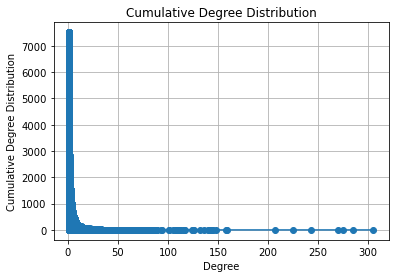

In [60]:
plt.plot(degree_sequence, cumulative_degrees, marker='o')
plt.xlabel("Degree")
plt.ylabel("Cumulative Degree Distribution")
plt.title("Cumulative Degree Distribution")
plt.grid(True)
plt.show()

In [ ]:
#plotting degree distribution of escorts
escort_degrees = dict(proj_G.degree())

plt.hist(escort_degrees.values(), bins=60, alpha=0.5, label='Escorts')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
proj_G_b = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n1.unique(), ratio=True)
buyers_degrees = dict(proj_G_b.degree())

plt.hist(buyers_degrees.values(), bins=60, alpha=0.5, label='Escorts')
plt.xscale('log')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.show()